## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [1]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [3]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location,even_odd_correlation
from plts import plot_raster_with_tuning_curve,plot_feature_arrow,plot_pca_scatter,plot_feature_color_bars
sys.path.append('../scripts')
from settings import PATHS, METHODS,EXCLUSION,INCREMENT
from pldm_settings import PLOT_PARAMS,SI_THRESHOLD,ALPHA,FEATURE_COLORS








In [4]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [5]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [6]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [7]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [8]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_22159/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [9]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [10]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [11]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


In [12]:
all_results

,unit_ind,session_id,label,spike_name,place_bins,spike_position,trial_changes,trial_Num,trial_place_bins,place_sem,...,place_fr_anova_surr_p_val,place_fr_anova_surr_z_score,place_fr_info_surr_p_val,place_fr_info_surr_z_score,is_place_anova,is_place_info,is_place_fr_anova,is_place_fr_info,channel,sessions
0,0,EU001_0_train_events.mat,3ldmicro2,['NSX098_1'],"[11.097516632672882, 11.143666364113184, 11.18...","[nan, nan, nan, nan, nan, 0.01982426470588236,...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[16.666666666666668, 15.266814761524644, 13.3...","[0.45015454524323173, 0.35786746381625456, 0.3...",...,0.908,-1.232867,0.921,-1.307244,False,False,False,False,98,EU001_0
1,1,EU001_0_train_events.mat,3ldmicro2,['NSX098_2'],"[0.48277980699855716, 0.5650605102830095, 0.64...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 7.587753533886536e-...","[0.0848389902899717, 0.07202675923901641, 0.07...",...,0.917,-1.365193,0.892,-1.206590,False,False,False,False,98,EU001_0
2,2,EU001_0_train_events.mat,3ldmicro3,['NSX099_1'],"[1.1842697233322237, 1.1720035563490543, 1.168...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 3.707393238536612e-06, 0...","[0.1321844774316897, 0.11195476677117569, 0.10...",...,0.772,-0.775108,0.832,-0.953273,False,False,False,False,99,EU001_0
3,3,EU001_0_train_events.mat,3ldmicro3,['NSX099_2'],"[0.2137445887445888, 0.3147921362445991, 0.413...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.1282067726497952, 0.10573047143648222, 0.10...",...,0.494,-0.052684,0.785,-0.796140,False,False,False,False,99,EU001_0
4,4,EU001_0_train_events.mat,3ldmicro4,['NSX100_1'],"[6.5327788530913535, 6.660508627001465, 6.6718...","[nan, nan, nan, nan, nan, 0.01982426470588236,...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[5.000000000000001, 5.377211596667435, 5.3477...","[0.47385927608353245, 0.35978170458897846, 0.3...",...,0.013,2.616979,0.026,2.235433,True,True,True,True,100,EU001_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,6,R1391T_0_train_events.mat,LB3,['NSX007_3'],"[0.860953282828283, 0.814623593592706, 0.70180...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[143, 322, 449, 582, 720, 806, 929, 1103, 1223...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.4549007440085697, 0.36531775648203685, 0.25...",...,0.412,0.147544,0.628,-0.431253,False,False,False,False,7,R1391T_0
386,0,R1414E_0_train_events.mat,3Ldmicro8,['NSX104_1'],"[6.895523313492065, 6.968529031072344, 7.06119...","[nan, nan, nan, nan, nan, nan, nan, nan, 0.042...","[142, 315, 458, 630, 752, 837, 919, 1029, 1146...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[7.142857142857143, 7.327544539679706, 6.9165...","[0.365760920546466, 0.3282870963799351, 0.3385...",...,0.327,0.346138,0.350,0.292491,False,False,False,False,104,R1414E_0
387,0,R1414E_1_train_events.mat,3Ldmicro8,['NSX104_1'],"[13.79444557178932, 14.112764445510411, 14.686...","[nan, nan, nan, nan, 0.011989999999999997, 0.0...","[115, 247, 362, 497, 694, 769, 891, 1017, 1149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[17.142857142857146, 13.873296509249924, 9.68...","[0.5776646084065195, 0.42601769035660875, 0.37...",...,0.029,2.020694,0.022,2.199174,False,False,True,True,104,R1414E_1
388,1,R1414E_1_train_events.mat,3Ldmicro8,['NSX104_2'],"[10.084128111471863, 9.967601988121892, 9.7421...","[nan, nan, nan, nan, 0.

In [13]:
# Display the original dataframe before filtering
print("Original dataframe shape:", all_results.shape)
print(all_results.columns)
all_results['firing_rate'] = all_results['fr_bins'].apply(lambda x: np.mean(x))
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))
# Create a filtered copy
results = deepcopy(all_results)

results = results[results['firing_rate'].astype(float) < EXCLUSION['RATE_MAX']]
results = results[results['firing_rate'].astype(float) > EXCLUSION['RATE_MIN']]
results = results[results['presence_ratio'].astype(float) > EXCLUSION['TOTAL_PRESENCE_RATIO']]
# Display the filtered dataframe
print("\nFiltered dataframe shape:", results.shape)

Original dataframe shape: (390, 32)
Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions'],
      dtype='object')

Filtered dataframe shape: (307, 34)


## Get Features 

In [14]:
## Peak Rate
results['peak_rate'] = results['fr_bins'].apply(np.max)

## Average Rate
results['average_rate'] = results['fr_bins'].apply(np.mean)

## SNR
results['peak_over_average_rate '] = results['peak_rate'] / results['average_rate']

## Place Field
place_field_results = results['fr_bins'].apply(lambda x: find_place_field(x))
results['place_field_width'] = place_field_results.apply(lambda x: x[0])
results['noise_bins'] = place_field_results.apply(lambda x: x[1])
results['labeled_fields'] = place_field_results.apply(lambda x: x[2])
results['N_place_fields'] = place_field_results.apply(lambda x: x[3])
results['place_field_peak_location'] = place_field_results.apply(lambda x: x[4])

## Trial Peak Location
trial_peak_results = results.apply(lambda row: find_place_location(row['trial_fr'], row['place_field_peak_location']), axis=1)
results['trial_peak_loc'] = trial_peak_results.apply(lambda x: x[0])
results['trial_peak_rate'] = trial_peak_results.apply(lambda x: x[1])
results['num_trials_close_to_peak'] = trial_peak_results.apply(lambda x: x[2])
results['place_field_consistency'] = trial_peak_results.apply(lambda x: x[3])

## Presence Ratio
results['presence_ratio'] = results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

## Even Odd Correlation
results['even_odd_correlation'] = results.apply(lambda row: even_odd_correlation(row['trial_fr']), axis=1)

In [15]:
# ## Compute Features
# # Initialize new columns with appropriate data types
# all_results['peak_rate'] = np.nan
# all_results['average_rate'] = np.nan
# all_results['SNR'] = np.nan
# all_results['place_field_bins'] = pd.Series([None] * len(all_results))
# all_results['noise_bins'] = pd.Series([None] * len(all_results))
# all_results['labeled_fields'] = pd.Series([None] * len(all_results))
# all_results['N_place_fields'] = pd.Series([None] * len(all_results))
# all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
# all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
# all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
# all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
# all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# # Calculate basic rate features
# all_results['peak_rate'] = all_results['place_bins'].apply(np.max)
# all_results['average_rate'] = all_results['place_bins'].apply(np.mean)
# all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# # Calculate place field features for each unit
# for i in range(len(all_results)):
#     # Forward direction analysis
#     (all_results.at[i,'place_field_bins'], 
#      all_results.at[i,'noise_bins'],
#      all_results.at[i,'labeled_fields'], 
#      all_results.at[i,'N_place_fields'],
#      all_results.at[i,'peak_rate'],
#      all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['place_bins'][i])

#     (all_results.at[i,'trial_peak_loc'],
#      all_results.at[i,'trial_peak_rate'], 
#      all_results.at[i,'num_trials_close_to_peak'],
#      all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_place_bins'][i], 
#                                                                                    all_results['place_field_peak_location'][i],tolerance = 6)



In [16]:
# all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

In [17]:
# print(all_results.columns)
# all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))

# # Create a filtered copy
# all_results = all_results[all_results['firing_rate'].astype(float) < 20]
# all_results = all_results[all_results['firing_rate'].astype(float) > .1]

# # Reset index
# all_results = all_results.reset_index(drop=True)

## Feature Estimation 

In [18]:
peak_rate = results['peak_rate']
average_rate = results['average_rate']
peak_over_average_rate = peak_rate / average_rate
place_field_width = results['place_field_width']
num_place_fields = results['N_place_fields']
place_field_consistency= results['place_field_consistency']
presence_ratio = results['presence_ratio']
even_odd_corr = results['even_odd_correlation']

In [25]:
place_info = results['place_fr_info']
place_anova = results['place_fr_anova']

features_df = pd.DataFrame({
    'Peak Rate': peak_rate,
    'Average Rate': average_rate,
    'Peak Over Average': peak_over_average_rate,
    'Place Field Width': place_field_width,
    'Num Place Fields':num_place_fields,
    'Place Field Consistency': place_field_consistency,
    'Presence Ratio': presence_ratio,
    'Even Odd Correlation': even_odd_corr,
    'place_info': place_info,
    'place_anova': place_anova
}).dropna()

In [20]:
# Drop 'place_info' and 'place_anova' columns for PCA features
features = features_df.drop(['place_info', 'place_anova'], axis=1)

## PCA Feature Input

In [24]:
features

,Peak Rate,Average Rate,Peak Over Average,Place Field Width,Num Place Fields,Place Field Consistency,Presence Ratio,Even Odd Correlation
0,13.039993,10.884508,1.198032,40,1,0.093750,1.000000,-0.102482
1,1.309524,0.697106,1.878514,40,1,0.078125,0.984375,-0.158293
2,2.060268,1.317807,1.563406,40,1,0.062500,1.000000,-0.125470
3,1.634115,0.459250,3.558226,24,12,0.093750,0.765625,-0.153243
4,10.551153,6.248726,1.688529,40,1,0.140625,1.000000,0.263249
...,...,...,...,...,...,...,...,...
382,1.062500,0.311632,3.409471,24,5,0.109375,0.140625,-0.187946
383,5.572917,3.459233,1.611027,40,1,0.031250,0.984375,0.297114
384,3.460813,2.410150,1.435933,39,1,0.046875,0.937500,-0.322559
385,1.653646,0.630090,2.624461,33,3,0.046875,0.515625,0.030353


## PCA

In [22]:
# Drop NaN values and scale the feature data
#mask = features.notna().all(axis=1)
#data_no_nan = features[mask]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Performing PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['unit_ind'] = features.index.map(all_results['unit_ind'])
pca_df['session_id'] = features.index.map(all_results['session_id'])

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Get the feature importance for first two components
feature_names = features.columns
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=feature_names
)


## Plot PCA

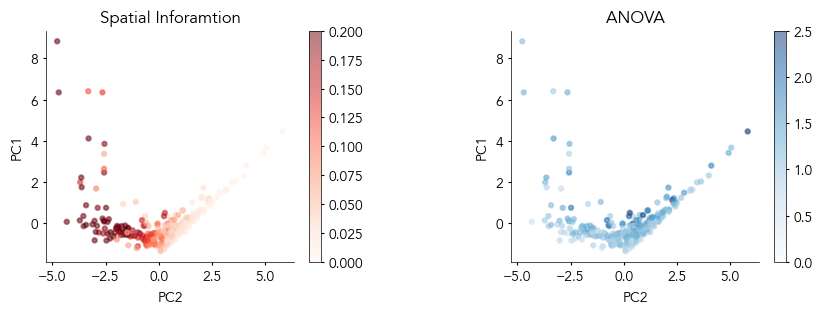

In [29]:
grid = make_grid(1,2, wspace=.5, hspace=.5, figsize=(10, 3))

# Configure plot parameters
plt.rcParams.update(PLOT_PARAMS)

# Plot spatial information
ax = get_grid_subplot(grid, 0, 0)
plot_pca_scatter(pca_result,color_info=features_df['place_info'],cmap = 'Reds',vmin = 0, vmax = .2,s = 10,title = 'Spatial Inforamtion',ylabel = 'PC1',xlabel = 'PC2',ax=ax)

ax = get_grid_subplot(grid,0,1)
plot_pca_scatter(pca_result,color_info=features_df['place_anova'],cmap = 'Blues',title = 'ANOVA',vmin=0,vmax = 2.5,s =10,ylabel = 'PC1',xlabel = 'PC2',ax=ax)


/Users/weijiazhang/code/AnalyzeTrain/FIGURE_HUMAN/../code/plts.py:323: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(


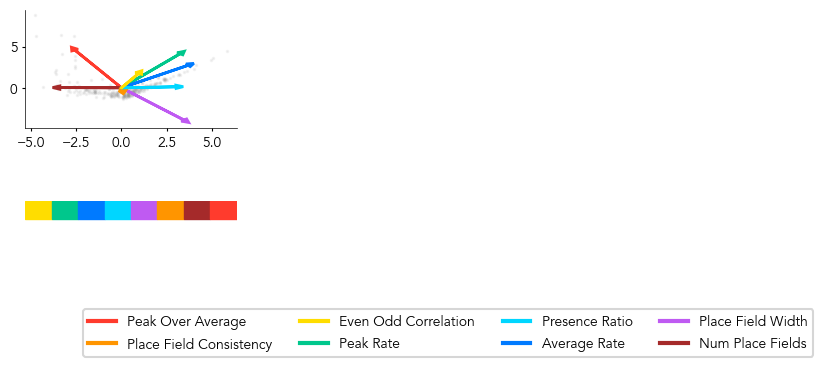

In [30]:
angles = []
for idx, feature_name in enumerate(feature_names):
    x, y = components.iloc[idx, 0], components.iloc[idx, 1]
    angle_deg = np.degrees(np.arctan2(y, x)) % 360  # 0-360 degrees
    # Shift so that 0 deg is at 12 o'clock (positive y-axis), increasing clockwise
    angle_from_12 = (90 - angle_deg) % 360
    angles.append((feature_name, angle_from_12, idx))

# Sort features by angle (clockwise from 12 o'clock)
angles_sorted = sorted(angles, key=lambda x: x[1])
angles_sorted
grid = make_grid(5, 6, wspace=1, hspace=4, height_ratios=[1,1,1,.1,1], figsize=(10, 5),
                 )
plt.rcParams.update(PLOT_PARAMS)

ax = get_grid_subplot(grid, slice(0,2), slice(0,2))
plot_pca_scatter(pca_result, color='grey', alpha = .1,ax=ax)

legend_handles = []
for idx, feature_name in enumerate(feature_names):
    color = FEATURE_COLORS[feature_name]
    plot_feature_arrow(components, feature_name,scale = 8,lw = 2,color=color, ax=ax)
    # Create a proxy artist for the legend
    handle = plt.Line2D([0], [0], color=color, lw=3, label=feature_name)
    legend_handles.append((handle, feature_name))
ordered_handles_labels = []
for feature in FEATURE_COLORS.keys():
    for handle, name in legend_handles:
        if name == feature:
            ordered_handles_labels.append((handle, name))
            break

handles, labels = zip(*ordered_handles_labels)
ax.legend(
    handles, labels,
    loc='lower center', bbox_to_anchor=(2, -2), ncol=4, frameon=True
)


ax = get_grid_subplot(grid, 2, slice(0,2))
plot_feature_color_bars(angles_sorted, FEATURE_COLORS,angles=angle_from_12,ax=ax)

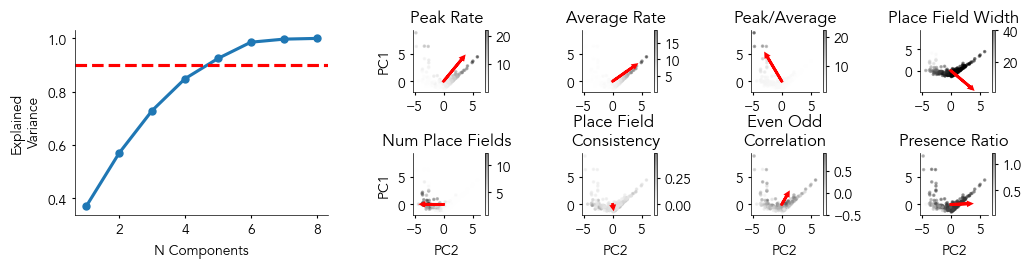

In [35]:
CELL_COLOR = 'Greys'
ARROW_COLOR = 'red'

# Set up grid for plots
grid = make_grid(3, 6,wspace=1,hspace=1,figsize=(12, 4))

plt.rcParams.update(PLOT_PARAMS)

# Plot cumulative explained variance
ax_var = get_grid_subplot(grid, slice(0, 2), slice(0, 2))
ax_var.plot(
    range(1, len(cumulative_variance_ratio) + 1),
    cumulative_variance_ratio,
    marker='o',
    markersize=5
)
ax_var.axhline(y=0.9, color='r', linestyle='--', label='90%')
ax_var.set_xlabel('N Components')
ax_var.set_ylabel('Explained\nVariance')
drop_spines(['top', 'right'], ax=ax_var)

# Feature plotting info: (column_key, display_name)
feature_plot_info = [
    ('Peak Rate', 'Peak Rate'),
    ('Average Rate', 'Average Rate'),
    ('Peak Over Average', 'Peak/Average'),
    ('Place Field Width', 'Place Field Width'),
    ('Num Place Fields', 'Num Place Fields'),
    ('Place Field Consistency', 'Place Field \nConsistency'),
    ('Even Odd Correlation', 'Even Odd\nCorrelation'),
    ('Presence Ratio', 'Presence Ratio'),
]

# Plot each feature as a colored PCA scatter with arrow
# Always start from the third column
for idx, (col_key, display_name) in enumerate(feature_plot_info):
    # Arrange 4 per row, always starting from the third column (col=2)
    row = 0 if idx < 4 else 1
    col = idx + 2 if idx < 4 else idx - 2

    ax = get_grid_subplot(grid, row, col)
    plot_pca_scatter(
        pca_result,
        color_info=features[col_key],
        cmap=CELL_COLOR,
        title=display_name,
        vmin = features[col_key].min() - .1,
        vmax = features[col_key].max() + .2,
        ylabel='PC1' if idx in (0, 4) else '',
        xlabel='PC2' if idx in (4, 5,6,7) else '',
        ax=ax
    )
    plot_feature_arrow(
        components,
        col_key,
        scale=8,
        lw=2,
        color=ARROW_COLOR,
        ax=ax)
